In [1]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score,  precision_recall_curve, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
from test_utils import plot_density, plot_precision_recall_curve, plot_roc_curve,calculate_dr_with_ar, plot_ar_vs_dr
warnings.filterwarnings('ignore')

### Load data

In [2]:
### es importante tranformar a category para poder usarlo en el XGBOOST si tranformar a dummies
df_train = pd.read_parquet('data/data_train.parquet')
categorical_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 
                       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 
                       'OCCUPATION_TYPE']


df_train[categorical_columns] = df_train[categorical_columns].astype('category')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20903 entries, 5024703 to 5149294
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   target               20903 non-null  int64   
 1   CODE_GENDER          20903 non-null  category
 2   FLAG_OWN_CAR         20903 non-null  category
 3   FLAG_OWN_REALTY      20903 non-null  category
 4   CNT_CHILDREN         20903 non-null  int64   
 5   AMT_INCOME_TOTAL     20903 non-null  int64   
 6   NAME_INCOME_TYPE     20903 non-null  category
 7   NAME_EDUCATION_TYPE  20903 non-null  category
 8   NAME_FAMILY_STATUS   20903 non-null  category
 9   NAME_HOUSING_TYPE    20903 non-null  category
 10  DAYS_EMPLOYED        20903 non-null  int64   
 11  FLAG_WORK_PHONE      20903 non-null  category
 12  FLAG_PHONE           20903 non-null  category
 13  FLAG_EMAIL           20903 non-null  category
 14  OCCUPATION_TYPE      20903 non-null  category
 15  CNT_FAM_MEMBERS 

In [3]:
### Split data train 
X_train = df_train.drop(columns=['target'])  
y_train = df_train['target']

In [4]:
### data details
print('X train dim', X_train.shape)
print('dist target', y_train.value_counts(normalize=True))

X train dim (20903, 15)
dist target target
1    0.922547
0    0.077453
Name: proportion, dtype: float64


### Train model

In [5]:
## hiperparámetros del XGB, casi todos por default, parametros de los folds para la validación cruzada
params = {'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'enable_categorical': True,
        'seed': 35}
xgb_model = xgb.XGBClassifier(**params)

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [6]:
### cross val usando average pres score
aucpr_scorer = make_scorer(average_precision_score, needs_proba=True)


cv_results = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=aucpr_scorer)

print(f"AUCPR por fold: {cv_results}")
print(f"AUCPR media: {cv_results.mean()}")

AUCPR por fold: [0.95391659 0.95879675 0.95757992]
AUCPR media: 0.9567644203265204


In [7]:
### cross val usando roc auc
aucpr_scorer = make_scorer(roc_auc_score, needs_proba=True)


cv_results = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=aucpr_scorer)

print(f"ROC-AUC por fold: {cv_results}")
print(f"ROC-AUC media: {cv_results.mean()}")

ROC-AUC por fold: [0.70223429 0.71834667 0.71614923]
ROC-AUC media: 0.7122433976387662


### Eval model

In [8]:
### entrenamo el model
params = {'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'enable_categorical': True,
        'seed': 35}
xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [9]:
### cargamos data test
df_test = pd.read_parquet('data/data_test.parquet')
categorical_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 
                       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 
                       'OCCUPATION_TYPE']


df_test[categorical_columns] = df_test[categorical_columns].astype('category')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5226 entries, 5033998 to 5116921
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   target               5226 non-null   int64   
 1   CODE_GENDER          5226 non-null   category
 2   FLAG_OWN_CAR         5226 non-null   category
 3   FLAG_OWN_REALTY      5226 non-null   category
 4   CNT_CHILDREN         5226 non-null   int64   
 5   AMT_INCOME_TOTAL     5226 non-null   int64   
 6   NAME_INCOME_TYPE     5226 non-null   category
 7   NAME_EDUCATION_TYPE  5226 non-null   category
 8   NAME_FAMILY_STATUS   5226 non-null   category
 9   NAME_HOUSING_TYPE    5226 non-null   category
 10  DAYS_EMPLOYED        5226 non-null   int64   
 11  FLAG_WORK_PHONE      5226 non-null   category
 12  FLAG_PHONE           5226 non-null   category
 13  FLAG_EMAIL           5226 non-null   category
 14  OCCUPATION_TYPE      5226 non-null   category
 15  CNT_FAM_MEMBERS  

In [10]:
### Split de test 
X_test = df_test.drop(columns=['target'])  
y_test = df_test['target']

In [11]:
### generamos las predicciones sobre test y las guardamos en el dataframe
df_test['pred_proba_model_1'] = xgb_model.predict_proba(X_test)[:,1]
df_test['pred_proba_model_1'].describe()

count    5226.000000
mean        0.924565
std         0.123651
min         0.042815
25%         0.925758
50%         0.963593
75%         0.981263
max         0.999793
Name: pred_proba_model_1, dtype: float64

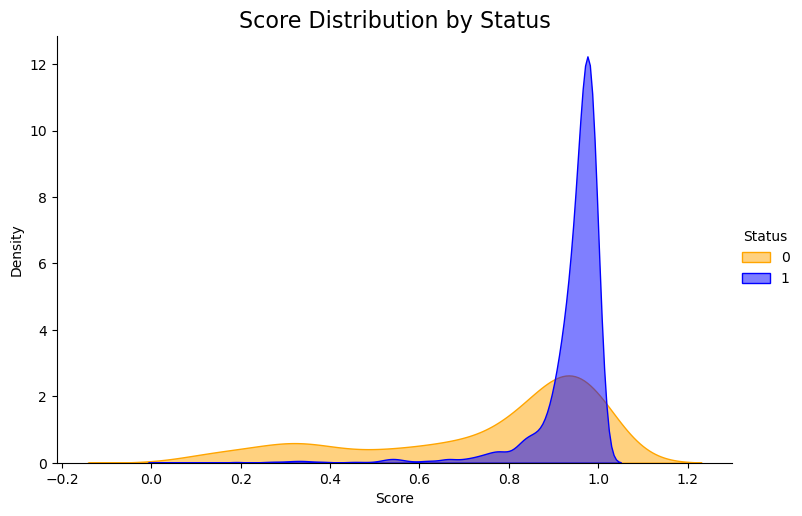

In [12]:
plot_density(df_test['pred_proba_model_1'], df_test['target'])
#El gráfico llega hasta 1.2 en el eje X porque seaborn.kdeplot estima la densidad de las distribuciones utilizando un suavizado 
#lo que puede extender los límites de los datos más allá del valor máximo real.

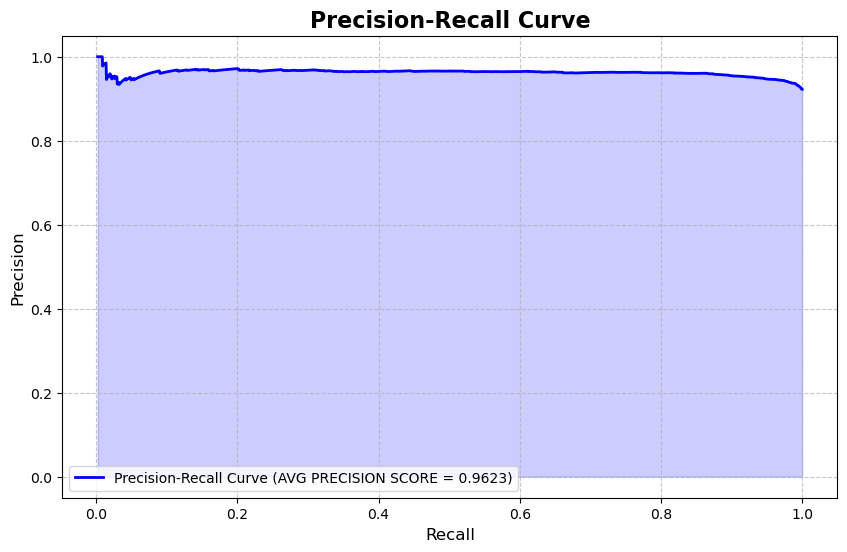

In [13]:
plot_precision_recall_curve(df_test['pred_proba_model_1'], df_test['target'])

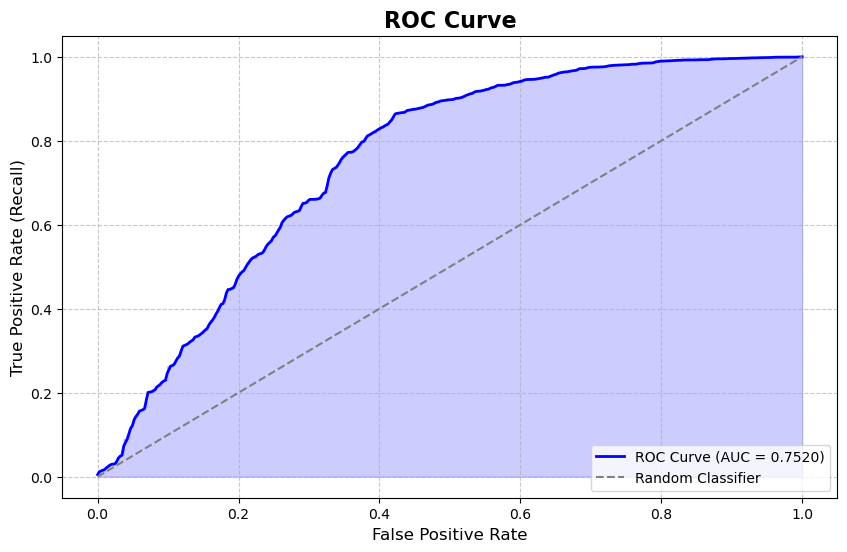

In [14]:
plot_roc_curve(df_test['pred_proba_model_1'], df_test['target'])

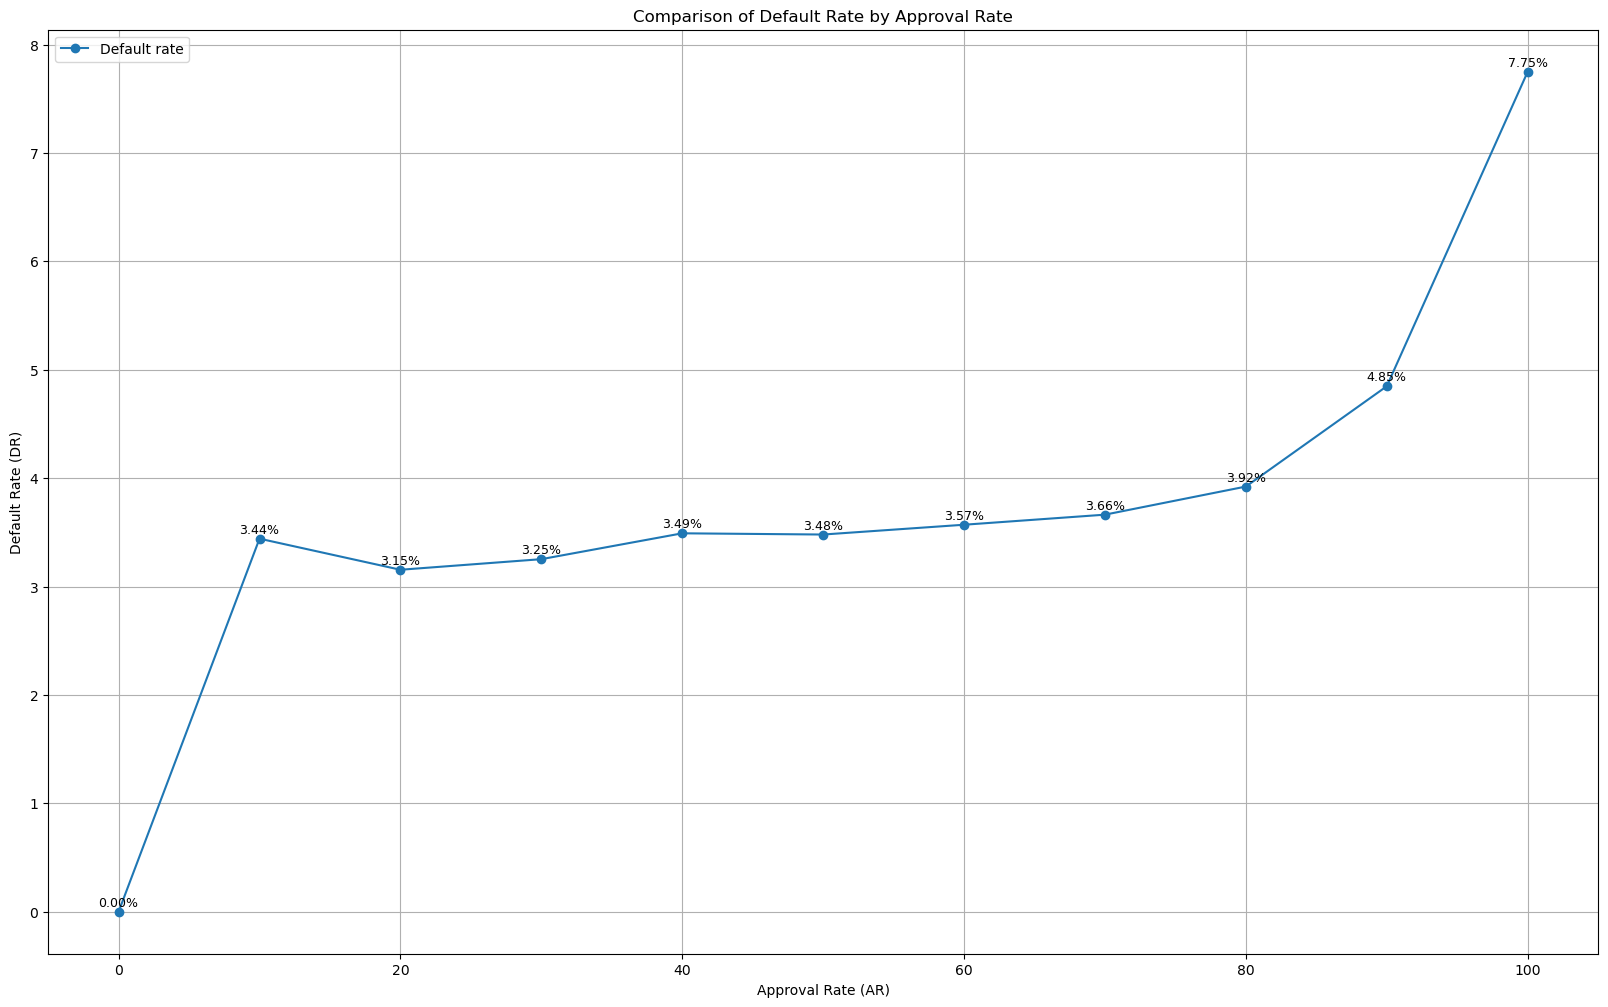

In [15]:
plot_ar_vs_dr(df_test['pred_proba_model_1'], df_test['target'])

### shap values

In [16]:
explainer = shap.TreeExplainer(xgb_model)

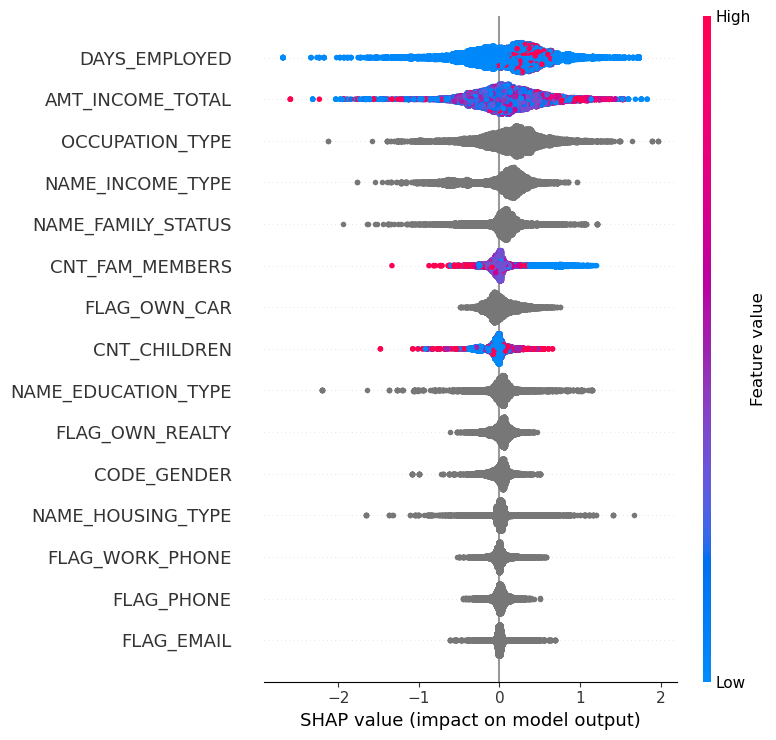

In [17]:
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="dot", show=False)

In [18]:
feature_importances = xgb_model.feature_importances_

importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
3,CNT_CHILDREN,0.082787
13,OCCUPATION_TYPE,0.080399
7,NAME_FAMILY_STATUS,0.074846
9,DAYS_EMPLOYED,0.072611
6,NAME_EDUCATION_TYPE,0.072242
10,FLAG_WORK_PHONE,0.071893
2,FLAG_OWN_REALTY,0.071411
8,NAME_HOUSING_TYPE,0.067349
5,NAME_INCOME_TYPE,0.067120
4,AMT_INCOME_TOTAL,0.064349
